## Predicting MISO Load from Hourly Temperature Observations using a Least-Squares Linear Model

In this notebook we perform the following steps:
* Obtain temperature observations from several weather stations in the MISO footprint
* Obtain the actual hourly MISO Load data
* Harmonize the hourly temperatures with the load data
* Predict the hourly load using a least-squares linear model

### Weather Data

Observation stations were chosen for geographical diversity and proximity to population centers.

In [2]:
from weather_data import get_station_df
from os.path import isfile
from datetime import *
from multiprocessing import cpu_count
from joblib import Parallel, delayed
import pandas as pd
import numpy as np
from pathlib import Path

parallel = Parallel(n_jobs=cpu_count())

stations_dict = {'IA' : ['DSM', 'CID'],
                 'MN' : ['DLH', 'JKJ', 'LYV', 'MSP', 'RST'], 
                 'WI' : ['MSN', 'MKE', 'EAU', 'GRB'],
                 'MI' : ['ANJ', 'GRR', 'LAN', 'DET', 'ARB'],
                 'IN' : ['EVV', 'FWA', 'IND', 'SBN', 'SPI'],
                 'IL' : ['BMI', 'CMI', 'ARR', 'PIA'],
                 'MO' : ['STL', 'COU', 'SGF', 'MKC'],
                 'MS' : ['HKS', 'TUP', 'MEI'],
                 'LA' : ['BTR', 'LFT', 'LCH', 'SHV', 'AEX'],
                 'TX' : ['LFK'] }

stations = [(state, station) for state in stations_dict.keys() for station in stations_dict[state]]

def download_file_path(state, station):
    Path("./data/").mkdir(exist_ok=True)
    return f'./data/{state}_{station}.parquet'

def est(yyyy, mm, dd, hh):
    return datetime(yyyy, mm, dd, hh, tzinfo=timezone(timedelta(hours=-5)))

In [3]:
first_hour = est(2015,  2, 1,  0)
last_hour  = est(2021, 12, 31, 23)
observation_dates = pd.date_range(start = first_hour, end = last_hour)
observation_hours = [d.replace(hour = h) for d in observation_dates for h in range(0, 24)]

def download_station(state, station):
    path = download_file_path(state, station) 
    if isfile(path):
        return pd.read_parquet(path)

    station = get_station_df(station, first_hour, last_hour)
    if station is None:
        print(f'Retrieve {station} failed')
        return None
    return station.to_parquet(path)

#_ = parallel(delayed(download_station)(state, station) for (state, station) in stations)

In [3]:
def build_hourly_df(state, station, observation_hours):
    w = pd.read_parquet(download_file_path(state, station))
    df = w[w['tmpf'] != 'M'].copy()
    df['valid'] = pd.to_datetime(df['valid'], utc = True)
    numeric_cols = ['tmpf', 'lat', 'lon']
    df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, axis=1)
    df = df.drop(columns=['feel'])
    idx = df.drop_duplicates('valid').set_index('valid').index.get_indexer(observation_hours, method='nearest')
    df = df.iloc[idx]
    df.loc[: , 'valid'] = df['valid'].dt.round(freq='H')
    return df.drop_duplicates('valid') 

dfs = parallel(delayed(build_hourly_df)(state, station, observation_hours) for (state, station) in stations)
df = pd.concat(dfs, ignore_index=True)
df

station                     valid   tmpf      lat      lon
0           DSM 2015-02-01 05:00:00+00:00  33.98  41.5339 -93.6531
1           DSM 2015-02-01 06:00:00+00:00  33.08  41.5339 -93.6531
2           DSM 2015-02-01 07:00:00+00:00  33.08  41.5339 -93.6531
3           DSM 2015-02-01 08:00:00+00:00  33.08  41.5339 -93.6531
4           DSM 2015-02-01 09:00:00+00:00  33.08  41.5339 -93.6531
...         ...                       ...    ...      ...      ...
2275820     LFK 2021-12-31 19:00:00+00:00  78.10  31.2340 -94.7500
2275821     LFK 2021-12-31 20:00:00+00:00  81.00  31.2340 -94.7500
2275822     LFK 2021-12-31 21:00:00+00:00  81.00  31.2340 -94.7500
2275823     LFK 2021-12-31 22:00:00+00:00  81.00  31.2340 -94.7500
2275824     LFK 2021-12-31 23:00:00+00:00  79.00  31.2340 -94.7500

[2275825 rows x 5 columns]

### Obtain the Regional MTLF and Actual Load for each Observation Hour

In [4]:
from rf_al_data import get_daily_rf_al_df

Path("./data/mtlf").mkdir(exist_ok=True)
forecast_output_dir = './data/mtlf'
# the actuals aren't available until the next day
actuals = get_daily_rf_al_df(first_hour, last_hour + timedelta(days=2.0), forecast_output_dir)
actuals

Market Day  HourEnding  Central MTLF (MWh)  Central ActualLoad (MWh)  \
1  2015-02-01           1               37796                  36585.39   
2  2015-02-01           2               36589                  35509.04   
3  2015-02-01           3               36067                  34970.90   
4  2015-02-01           4               35855                  34708.83   
5  2015-02-01           5               35835                  34709.81   
..        ...         ...                 ...                       ...   
20 2021-12-31          20               37097                  35527.32   
21 2021-12-31          21               36329                  34442.06   
22 2021-12-31          22               35383                  33472.41   
23 2021-12-31          23               33996                  32390.22   
24 2021-12-31          24               32491                  31245.78   

    North MTLF (MWh)  North ActualLoad (MWh)  South MTLF (MWh)  \
1              15885                16150.30             16067   
2              15517                15713.40             15591   
3              15187                15381.56             15272   
4              15060                15239.59             15122   
5              15027                15229.09             15080   
..               ...                     ...               ...   
20             20035                19940.40             20204   
21             19699                19477.29             19658   
22             19408                19040.22             19096   
23             19038                18672.17             18403   
24             18571                18504.47             17659   

    South ActualLoad (MWh)  MISO MTLF (MWh)  MISO ActualLoad (MWh)  
1                 16163.39            69748               68899.08  
2                 15571.34            67697               66793.78  
3                 15137.39            66526               65489.85  
4                 14935.61            66037               64884.03  
5                 14750.43            65942               64689.33  
..                     ...              ...                    ...  
20                20083.71            77336               75551.43  
21                19543.14            75686               73462.49  
22                18934.14            73887               71446.77  
23                18469.10            71437               69531.49  
24                18126.86            68721               67877.11  

[60624 rows x 10 columns]

### Harmonize Features with Actuals

There are a number of lacunae in the weather observations.

In [5]:
def mktime_idx(row): 
    return datetime.combine(row['Market Day'].date(), time(row['HourEnding'] - 1), timezone(timedelta(hours = -5)))

actuals['time_idx'] = actuals.apply(mktime_idx, axis = 1)

In [6]:
actuals.to_parquet('./data/actuals_mtlf.parquet')
actuals

Market Day  HourEnding  Central MTLF (MWh)  Central ActualLoad (MWh)  \
1  2015-02-01           1               37796                  36585.39   
2  2015-02-01           2               36589                  35509.04   
3  2015-02-01           3               36067                  34970.90   
4  2015-02-01           4               35855                  34708.83   
5  2015-02-01           5               35835                  34709.81   
..        ...         ...                 ...                       ...   
20 2021-12-31          20               37097                  35527.32   
21 2021-12-31          21               36329                  34442.06   
22 2021-12-31          22               35383                  33472.41   
23 2021-12-31          23               33996                  32390.22   
24 2021-12-31          24               32491                  31245.78   

    North MTLF (MWh)  North ActualLoad (MWh)  South MTLF (MWh)  \
1              15885                16150.30             16067   
2              15517                15713.40             15591   
3              15187                15381.56             15272   
4              15060                15239.59             15122   
5              15027                15229.09             15080   
..               ...                     ...               ...   
20             20035                19940.40             20204   
21             19699                19477.29             19658   
22             19408                19040.22             19096   
23             19038                18672.17             18403   
24             18571                18504.47             17659   

    South ActualLoad (MWh)  MISO MTLF (MWh)  MISO ActualLoad (MWh)  \
1                 16163.39            69748               68899.08   
2                 15571.34            67697               66793.78   
3                 15137.39            66526               65489.85   
4                 14935.61            66037               64884.03   
5                 14750.43            65942               64689.33   
..                     ...              ...                    ...   
20                20083.71            77336               75551.43   
21                19543.14            75686               73462.49   
22                18934.14            73887               71446.77   
23                18469.10            71437               69531.49   
24                18126.86            68721               67877.11   

                    time_idx  
1  2015-02-01 00:00:00-05:00  
2  2015-02-01 01:00:00-05:00  
3  2015-02-01 02:00:00-05:00  
4  2015-02-01 03:00:00-05:00  
5  2015-02-01 04:00:00-05:00  
..                       ...  
20 2021-12-31 19:00:00-05:00  
21 2021-12-31 20:00:00-05:00  
22 2021-12-31 21:00:00-05:00  
23 2021-12-31 22:00:00-05:00  
24 2021-12-31 23:00:00-05:00  

[60624 rows x 11 columns]

In [ ]:
p = df.pivot(index='valid', columns='station', values='tmpf').dropna()
data = p.join(actuals.set_index('time_idx'), how='inner')

(n, _) = data.shape
(num_weather_observations, _) = df.groupby('valid').count().shape
(num_load_observations, _) = actuals.shape
(num_weather_observations, num_load_observations, len(observation_hours), n)

(60610, 60624, 60624, 40639)

### Perform a Least-Squares Fit

In [6]:
import numpy as np

y = data['MISO ActualLoad (MWh)']
def fit_lstsq(features, data, intercept = None):
    features_df = data[features].copy()
    if(intercept):
        features_df[intercept] = np.ones(features_df.shape[0])
    (A, [rss], _, _) = np.linalg.lstsq(features_df, y, rcond=None)
    score = 1 - (rss / np.sum(np.power(y - np.mean(y), 2)))
    return (A, features_df, rss, score)

station_temps = [s for l in stations_dict.values() for s in l]
(A, X, rss, linear_score) = fit_lstsq(station_temps + ['HourEnding'], data, intercept='b')
miso_rss = np.sum(np.power(data['MISO ActualLoad (MWh)'] - data['MISO MTLF (MWh)'], 2))
f"Linear Model RSS = {rss:.1e} vs MTLF RSS = {miso_rss:.1e}"

'Linear Model RSS = 3.7e+12 vs MTLF RSS = 7.6e+10'

Matplotlib is building the font cache; this may take a moment.


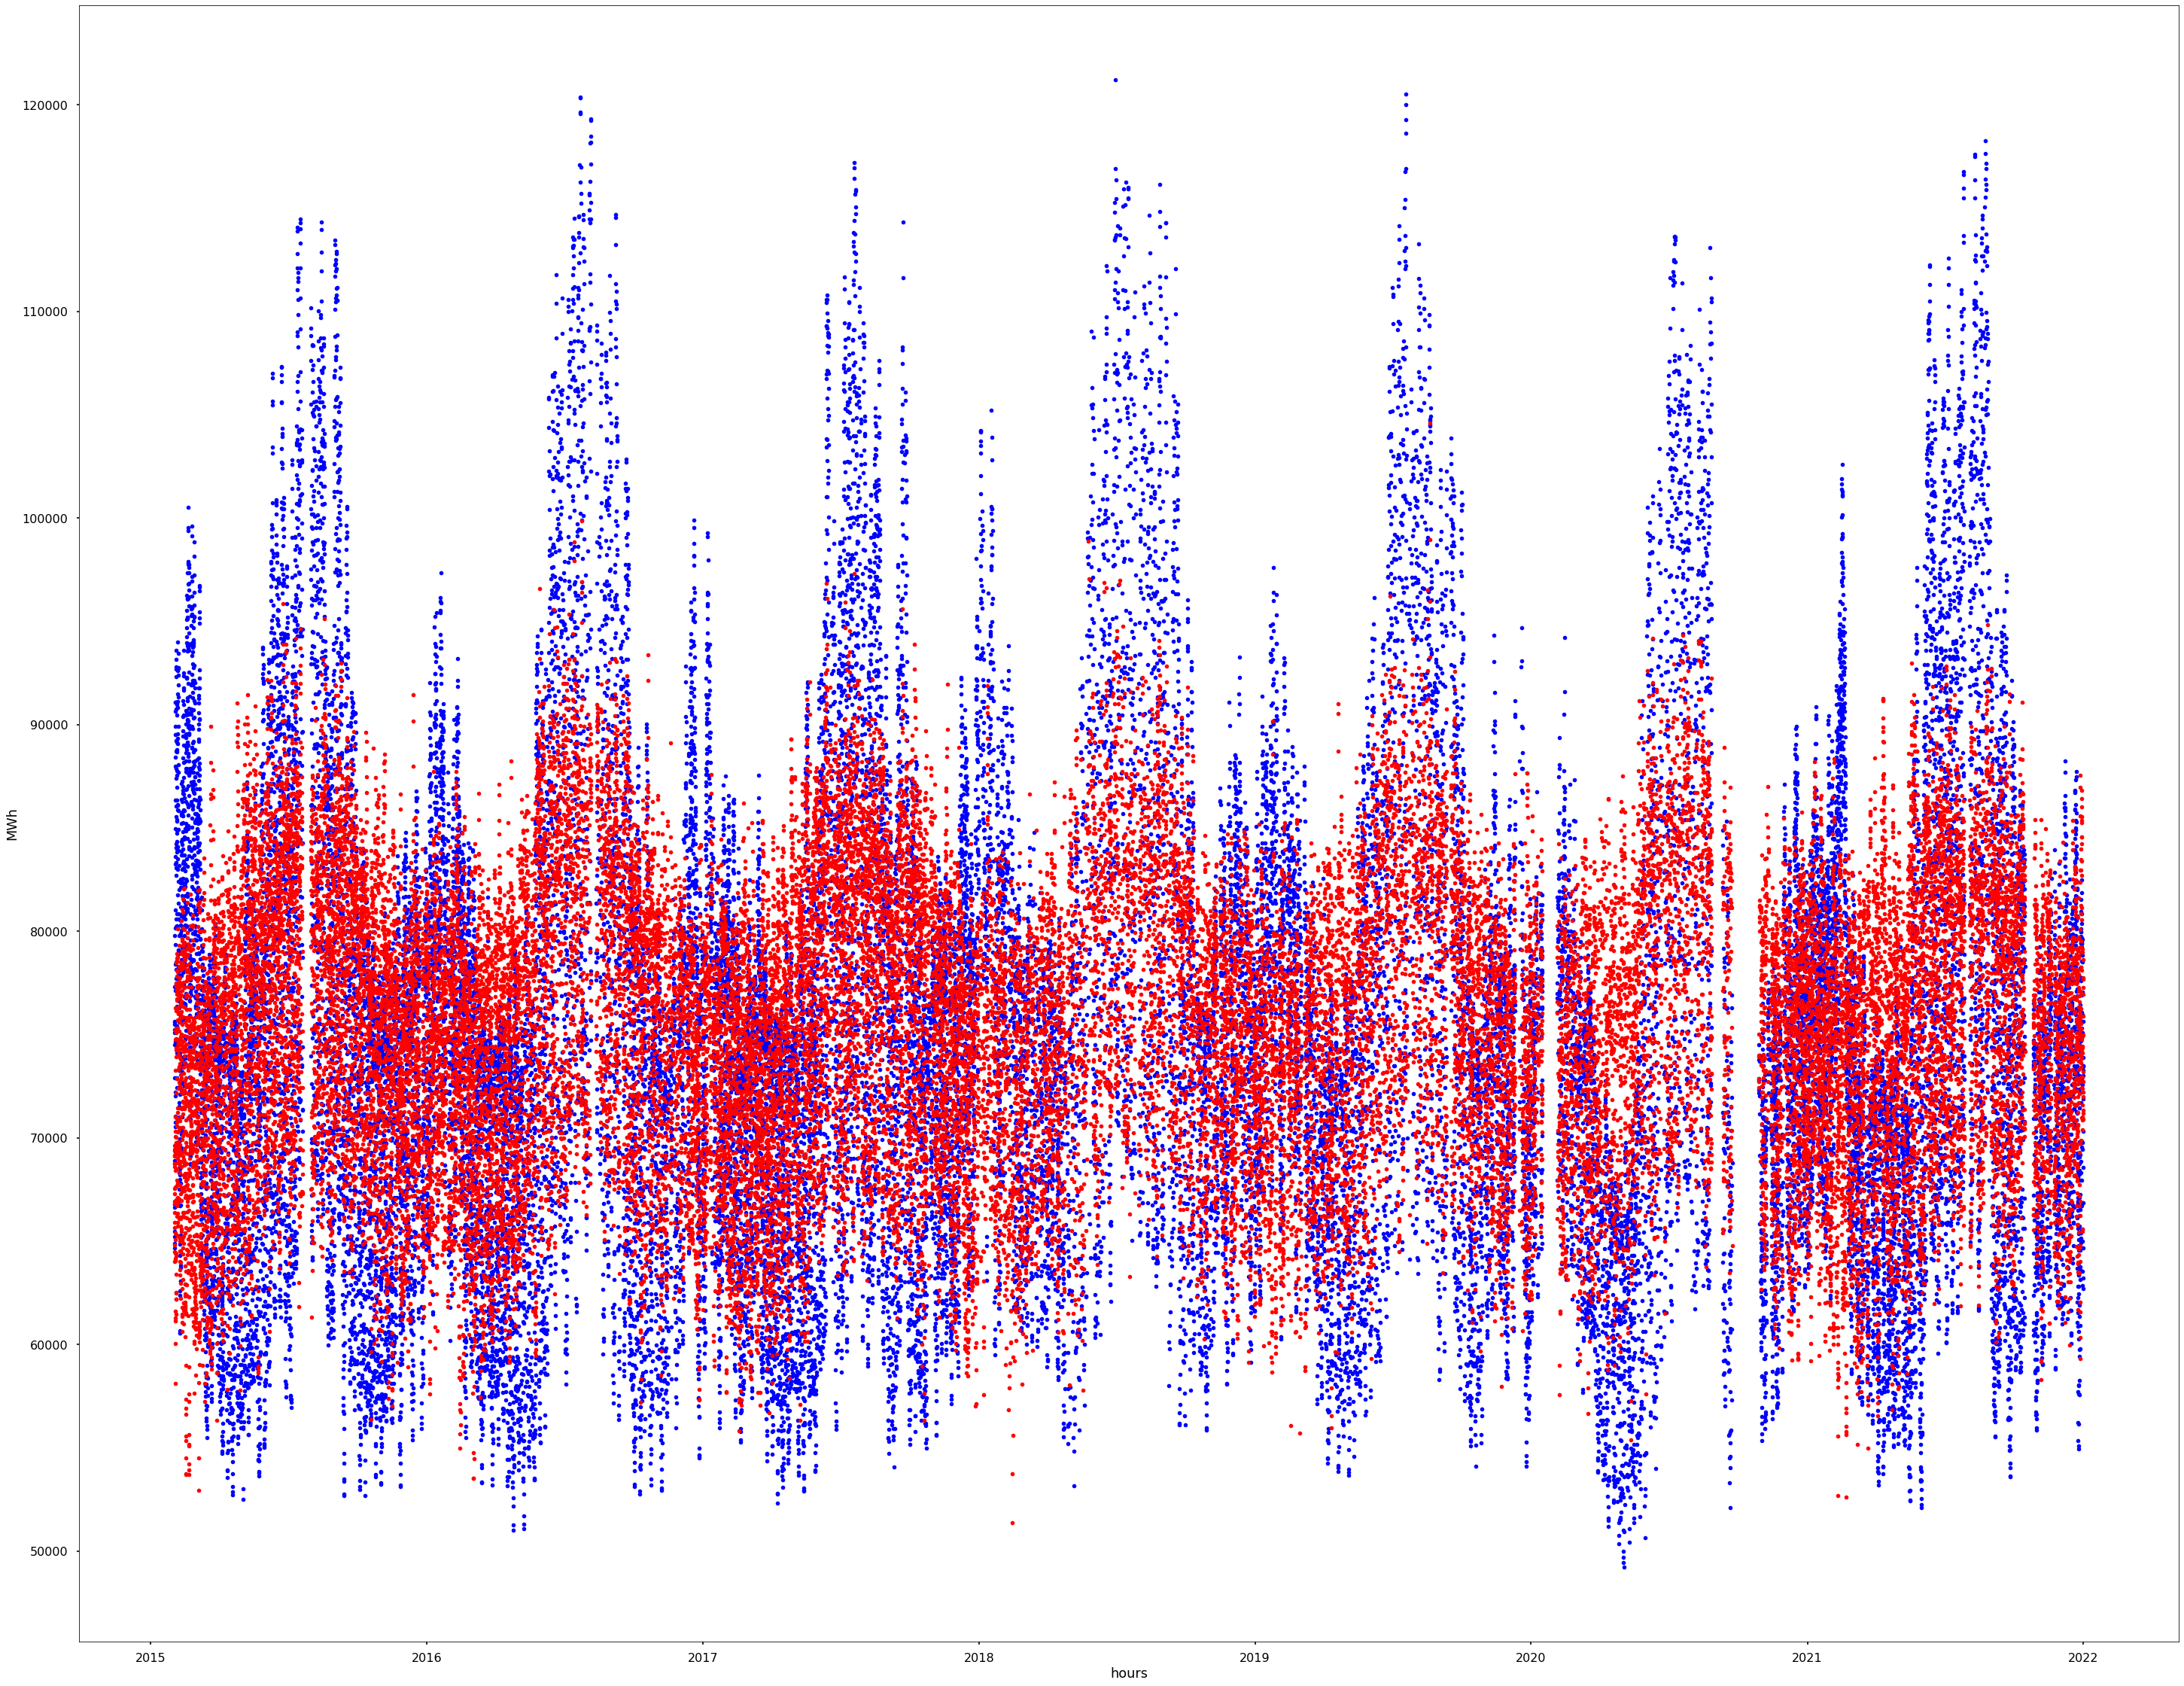

In [7]:
import matplotlib.pyplot as plt

plt.style.use('seaborn-poster')

def plot_result(yhat, y, hours):
    plt.figure(figsize = (50, 40))
    plt.plot(hours, y, 'b.')
    plt.plot(hours, yhat, 'r.')
    plt.xlabel('hours')
    plt.ylabel('MWh')
    plt.show()

plot_result(np.inner(A, X), data['MISO ActualLoad (MWh)'], data.index)

This model seems to captures some of seasonality but also goes against the seasonal trend with regularity. Moreover it cannot obtain the extrema in most time perods.

## Feature Engineering: Business Hours

Can we improve the performance of the model by introducing business hours into the feature set?

In [8]:
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay, BusinessHour

federal_business_days = CustomBusinessDay(calendar=USFederalHolidayCalendar())
bh = BusinessHour()
def is_biz_hour(d):
    return federal_business_days.is_on_offset(d) and bh.is_on_offset(d)
data['IsBusinessHour'] = data.index.to_series().apply(lambda d: 1 if is_biz_hour(d) else 0)

In [10]:
biz_hour_features = station_temps + ['HourEnding', 'IsBusinessHour']
(A, X, rss, _) = fit_lstsq(biz_hour_features, data, intercept='b')
f"Linear Model RSS = {rss:.1e} vs MTLF RSS = {miso_rss:.1e}"

'Linear Model RSS = 3.5e+12 vs MTLF RSS = 7.6e+10'

This is a very slight improvement. This might have been anticipated from our plot, as the seasonal trend's inability to capture the extrema is the major source of loss.

In [11]:
(np.abs(A).min(), np.abs(A).max())

(0.13753846451323426, 60179.81105483486)

The spread of the coefficients isn't too large, but let's try Ridge regression anyway.

In [12]:
from sklearn.linear_model import Ridge
features_df = data[biz_hour_features].copy()
ridge = Ridge()
ridge.fit(features_df, y)
(ridge.score(features_df, y), linear_score)

(0.3785493010020966, 0.33804734068200537)

A clear, but small improvement comes from penalizing larger coefficients.

In [13]:
(np.abs(ridge.coef_).min(), np.abs(ridge.coef_).max())

(0.13672879590165535, 5854.6923763939685)

## Polynomial Regression

In [15]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

In [19]:
poly_features = PolynomialFeatures(degree=3)
X_poly = poly_features.fit_transform(data[biz_hour_features].copy())
poly_reg = LinearRegression()
poly_reg.fit(X_poly, y)

LinearRegression()

In [20]:
poly_reg.score(X_poly,y)

0.9641379989891093

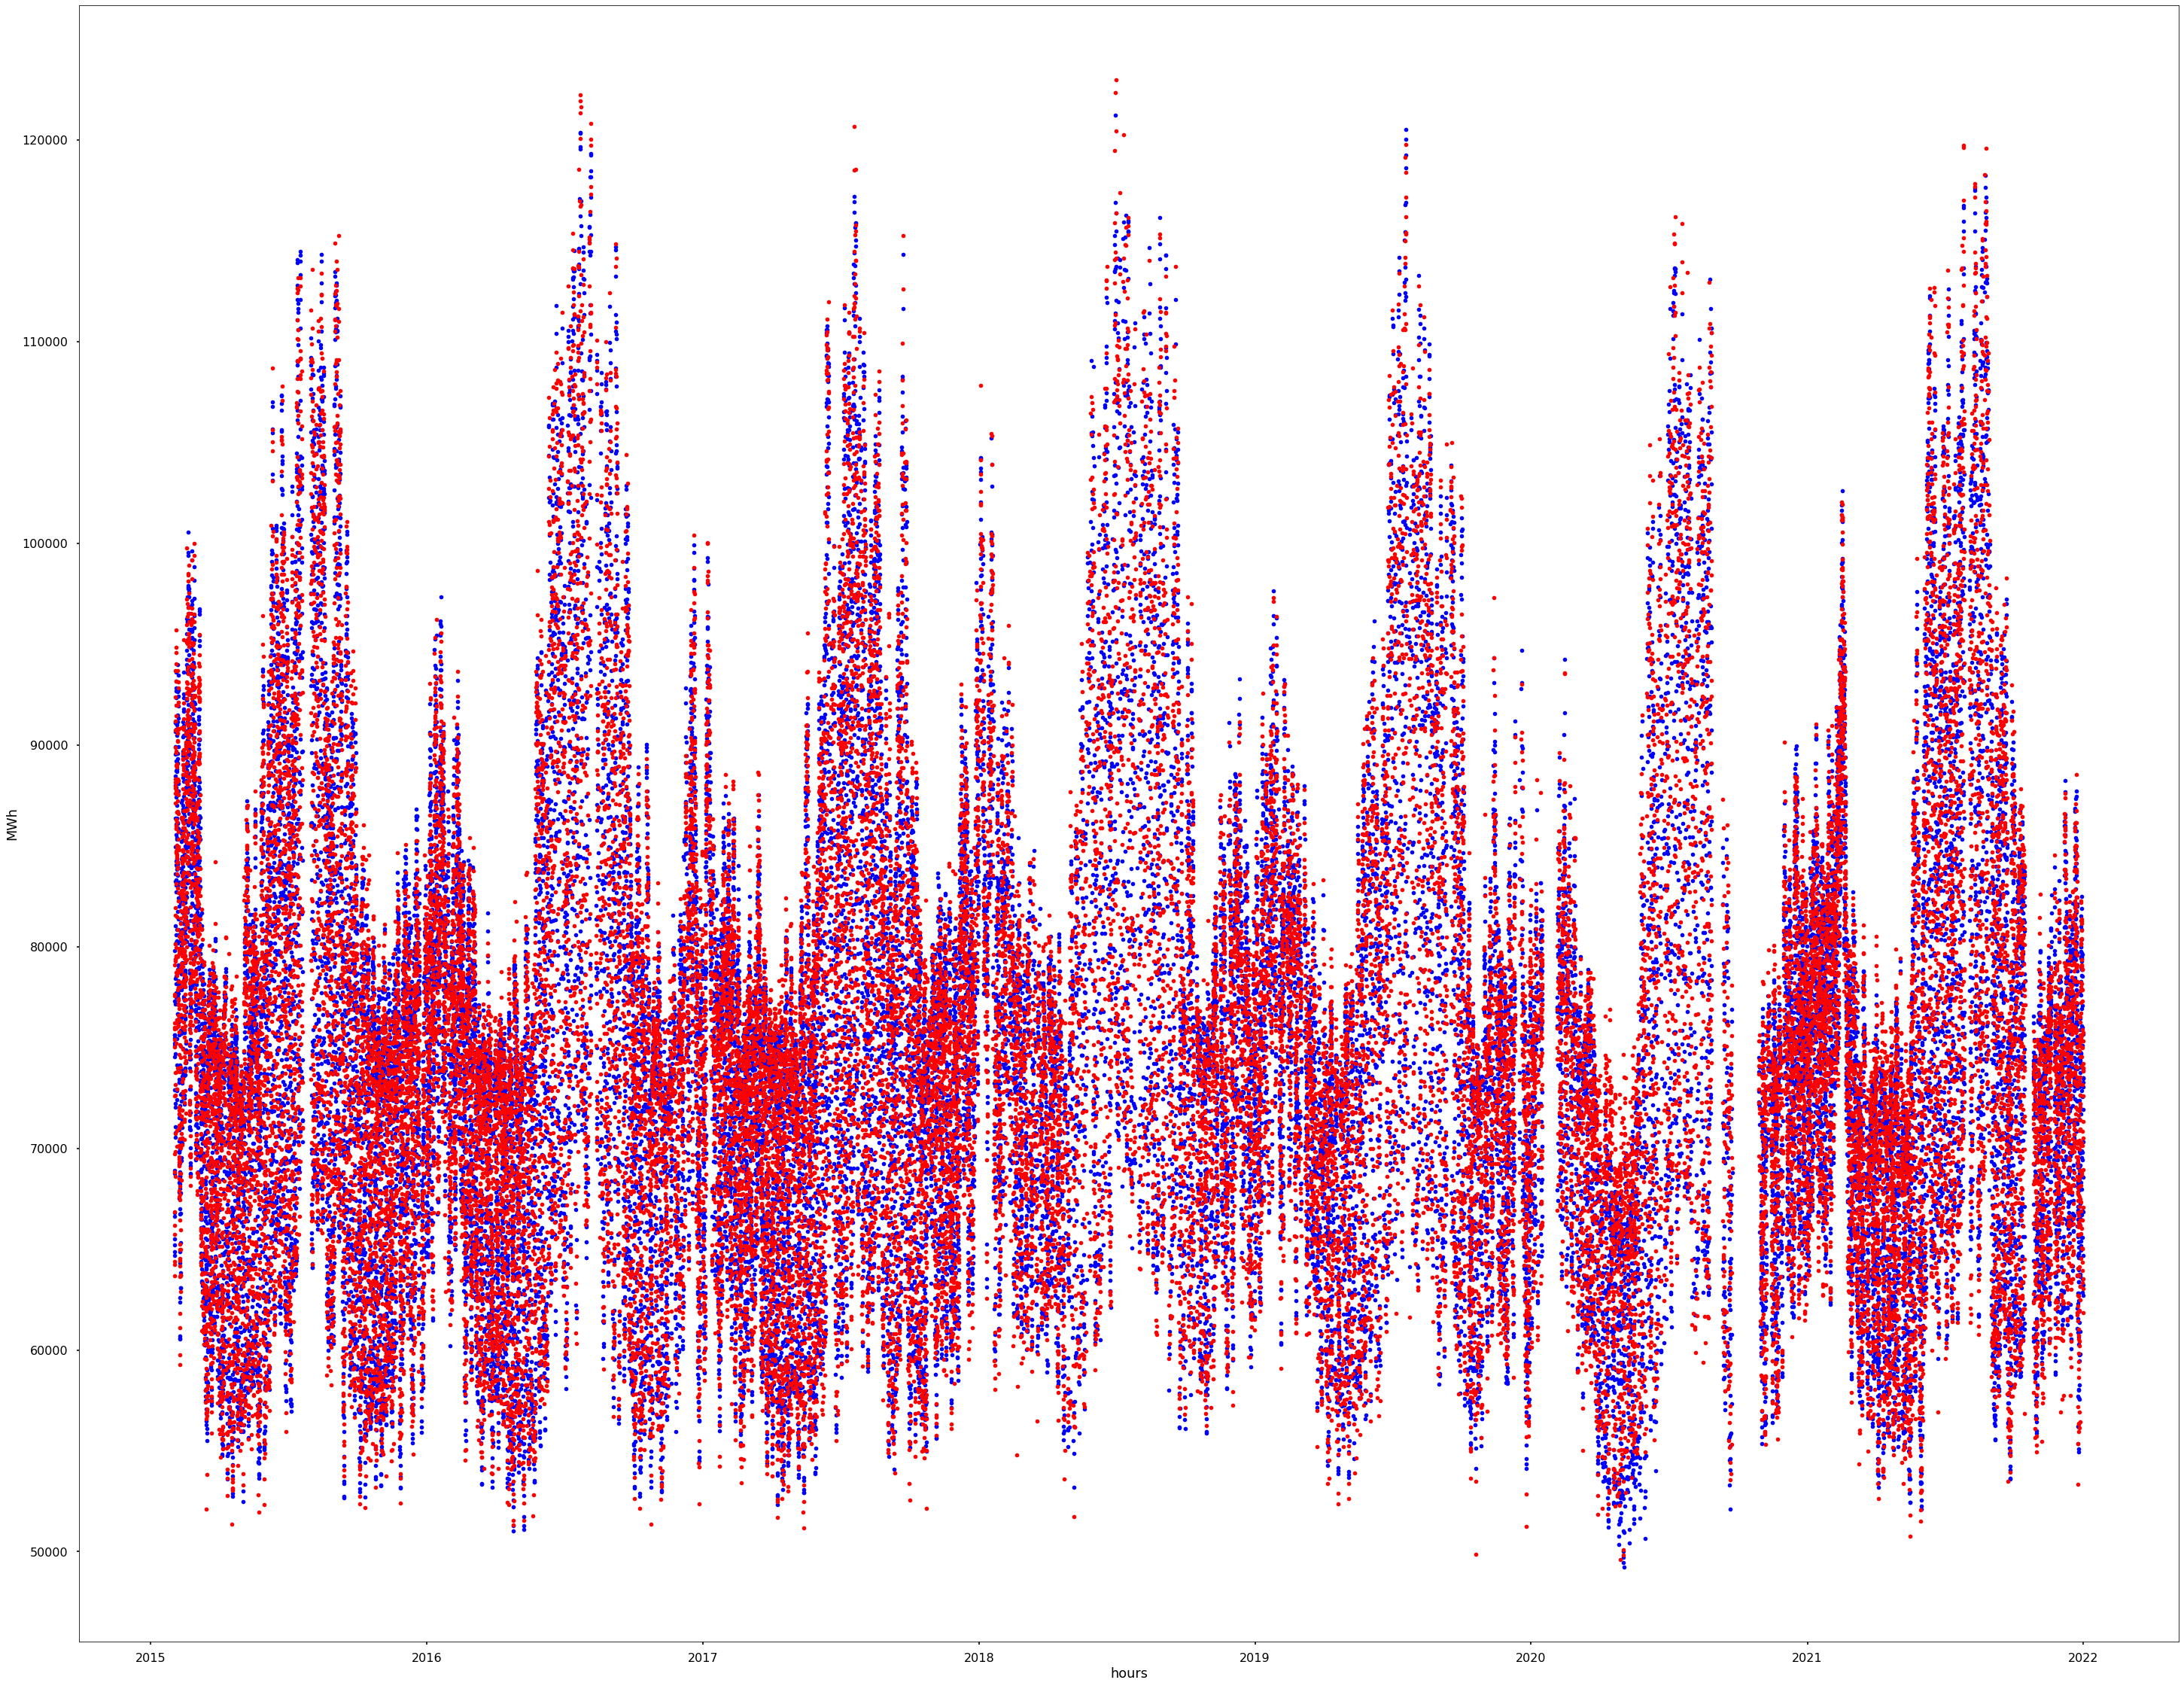

In [ ]:
plot_result(poly_reg.predict(X_poly), y, data.index)

In [ ]:
ridge = Ridge()
ridge.fit(X_poly, y)
(ridge.score(X_poly, y), linear_score)

/home/christopher/.local/share/virtualenvs/mml-2hCKCgTc/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=7.06797e-20): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


(0.9641217678970921, 0.3380473406820059)

In [ ]:
(np.max(X_poly[1]), np.min(X_poly[1]))

(216865.15251199997, 0.0)

In [18]:
poly_features_2 = PolynomialFeatures(degree=2, interaction_only=True)
X_poly_2 = poly_features_2.fit_transform(data[biz_hour_features].copy())
poly_reg_2 = LinearRegression()
poly_reg_2.fit(X_poly_2, y)
poly_reg_2.score(X_poly_2, y)

0.8347140391687556

### Split Training from Validation Data

In [30]:
X_train = data[biz_hour_features].sample(frac=0.8)
X_test = data[biz_hour_features].drop(X_train.index)
y_train = y.drop(X_test.index)
y_test = y.drop(X_train.index)

In [95]:
from sklearn.pipeline import make_pipeline
split_poly_pipeline = make_pipeline(PolynomialFeatures(degree=3, interaction_only=True), Ridge())
split_poly_pipeline.fit(X_train, y_train)

/home/ca/.local/share/virtualenvs/mml-4gMQx5WG/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=1.05077e-19): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


Pipeline(steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=3, interaction_only=True)),
                ('ridge', Ridge())])

In [54]:
poly3_ridge_rsquared = split_poly_pipeline.score(X_test, y_test)
poly3_ridge_rsquared

-0.7622827470465692

In [96]:
X_train_poly2 = split_poly_pipeline[:-1].transform(X_train)
X_test_poly2 = split_poly_pipeline[:-1].transform(X_test)

In [97]:
import statsmodels.api as sm

model = sm.OLS(y_train, X_train_poly2).fit()

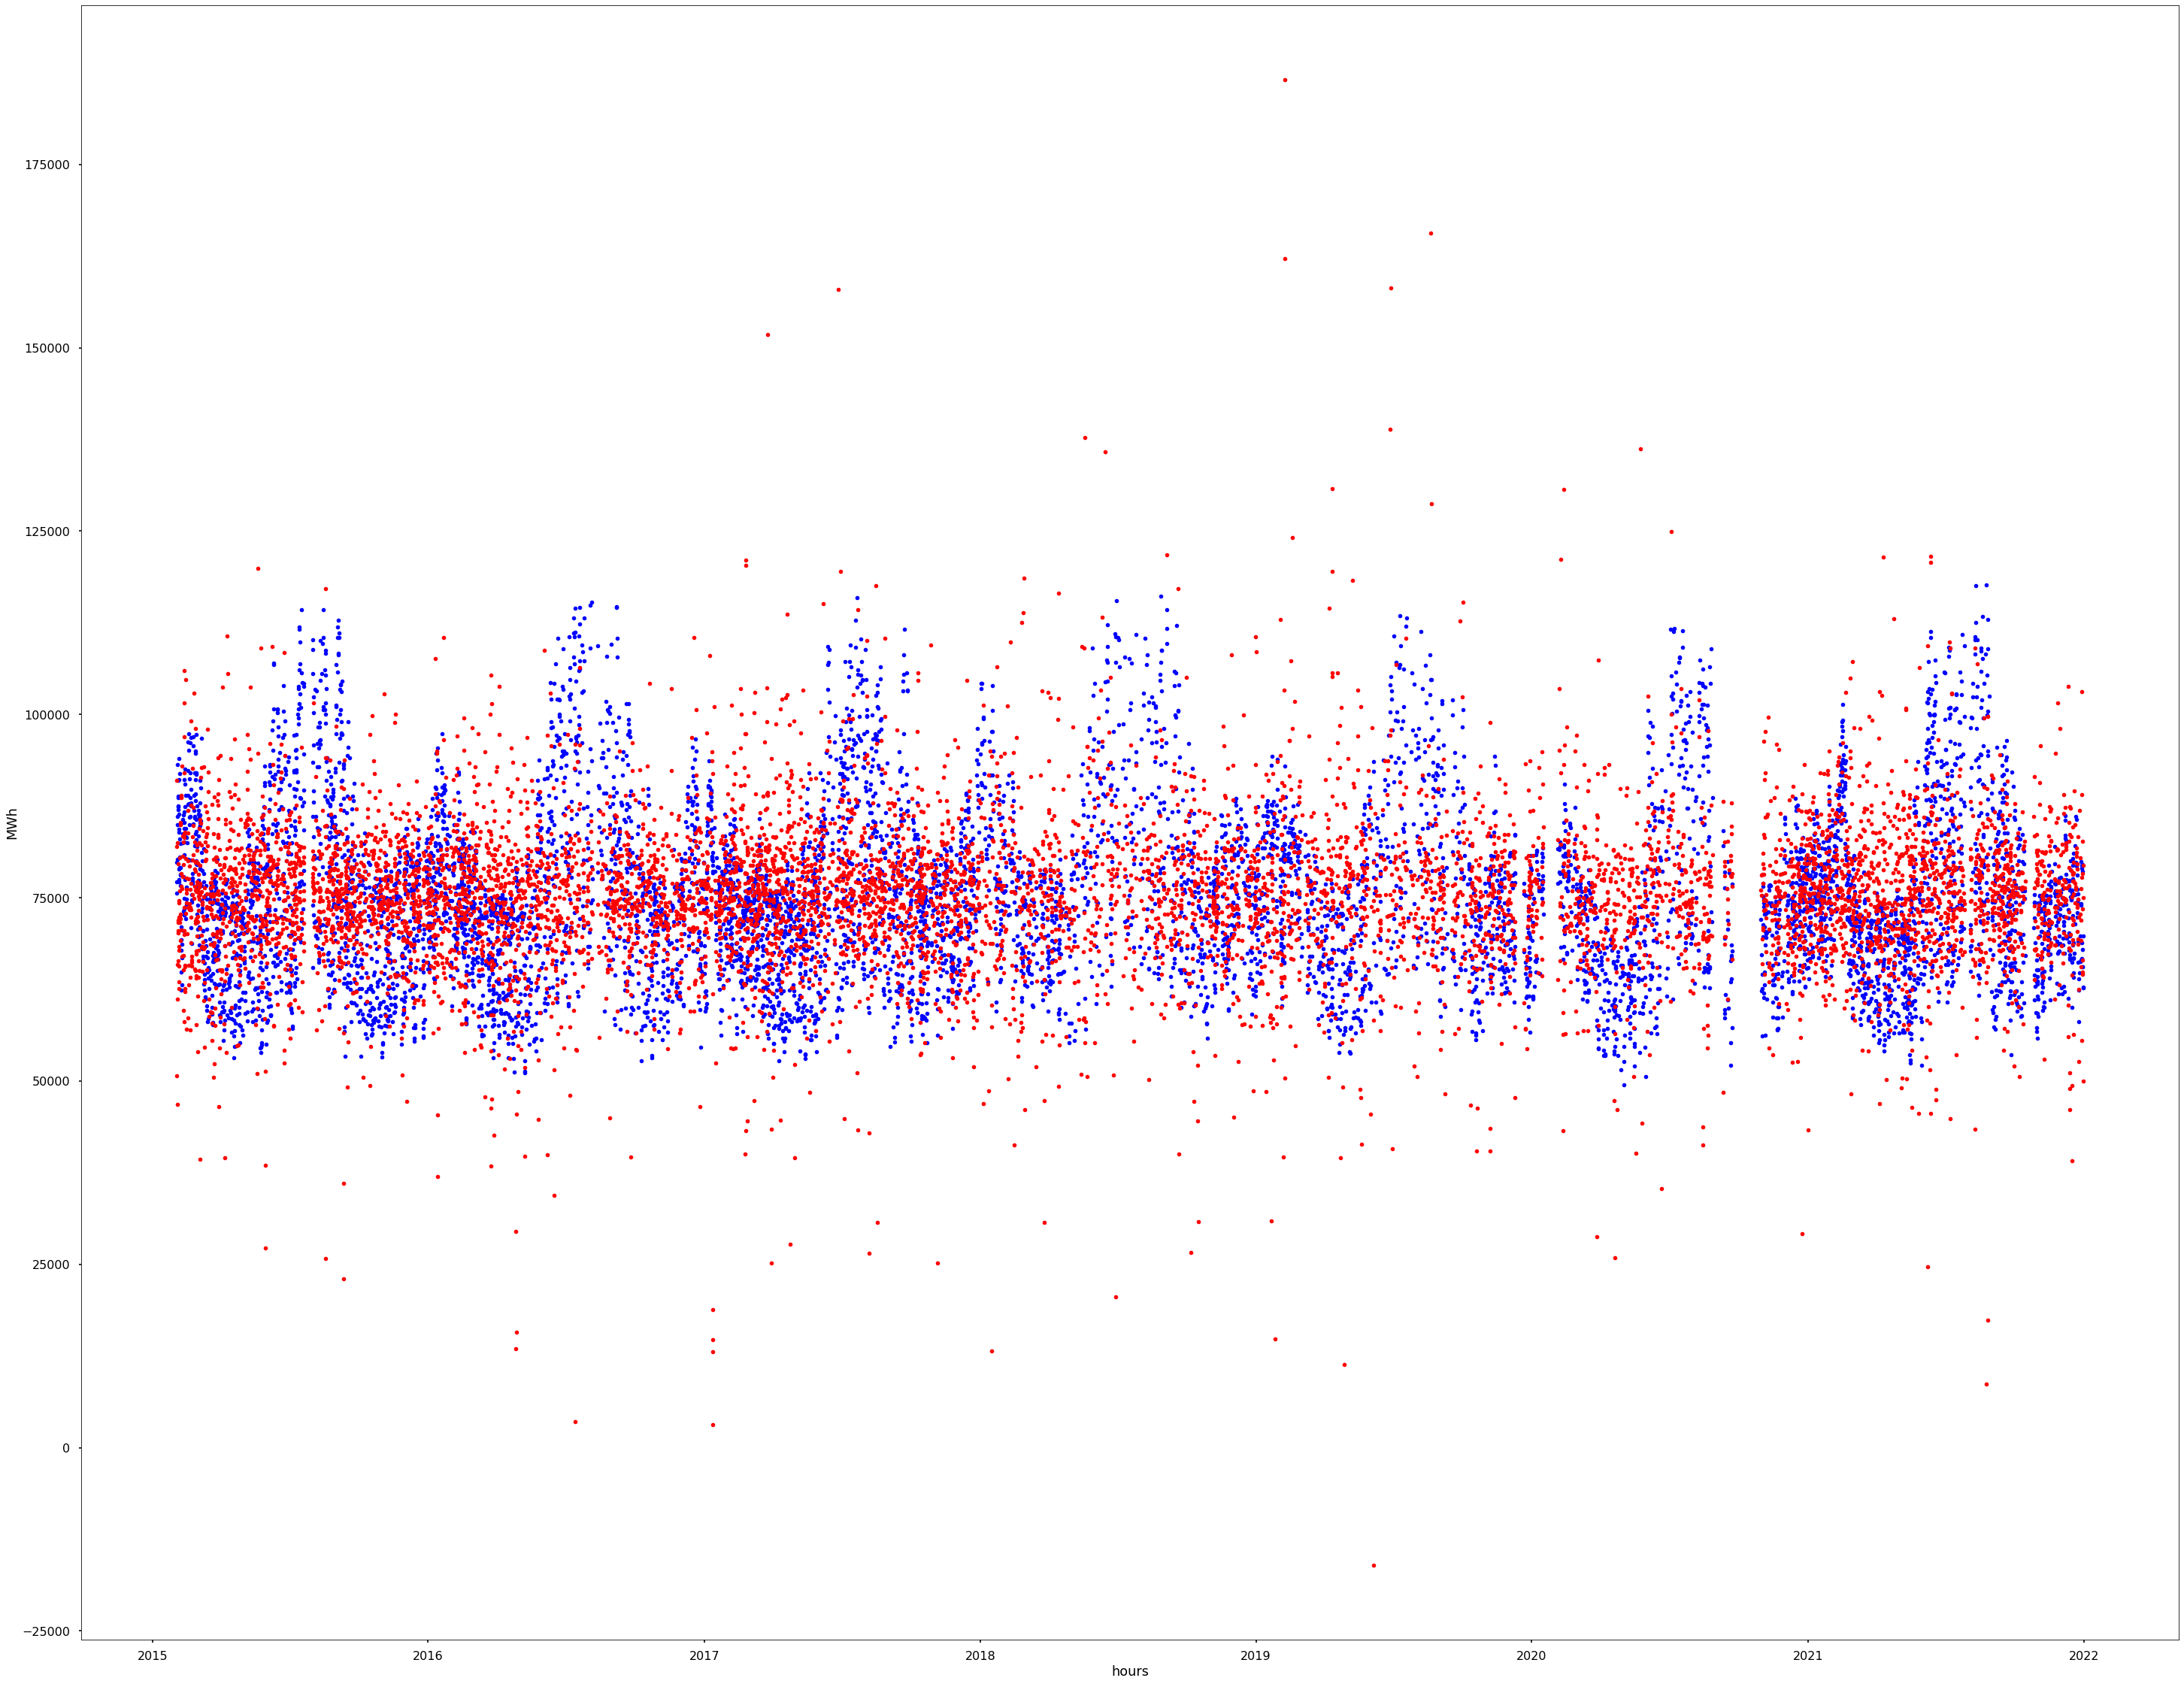

In [98]:
ypred = model.predict(X_test_poly2)
plot_result(ypred, y_test, X_test.index)

In [99]:
len([i for (i, v) in enumerate(model.pvalues) if v < 0.05])

538

In [100]:
model.pvalues.size

10701

In [106]:
good_features_idx = [i for (i, v) in enumerate(model.pvalues) if v < 0.05]
X_train_poly_good = X_train_poly2[:,good_features_idx]
X_test_poly_good = X_test_poly2[:,good_features_idx]

model = sm.OLS(y_train, X_train_poly_good).fit()

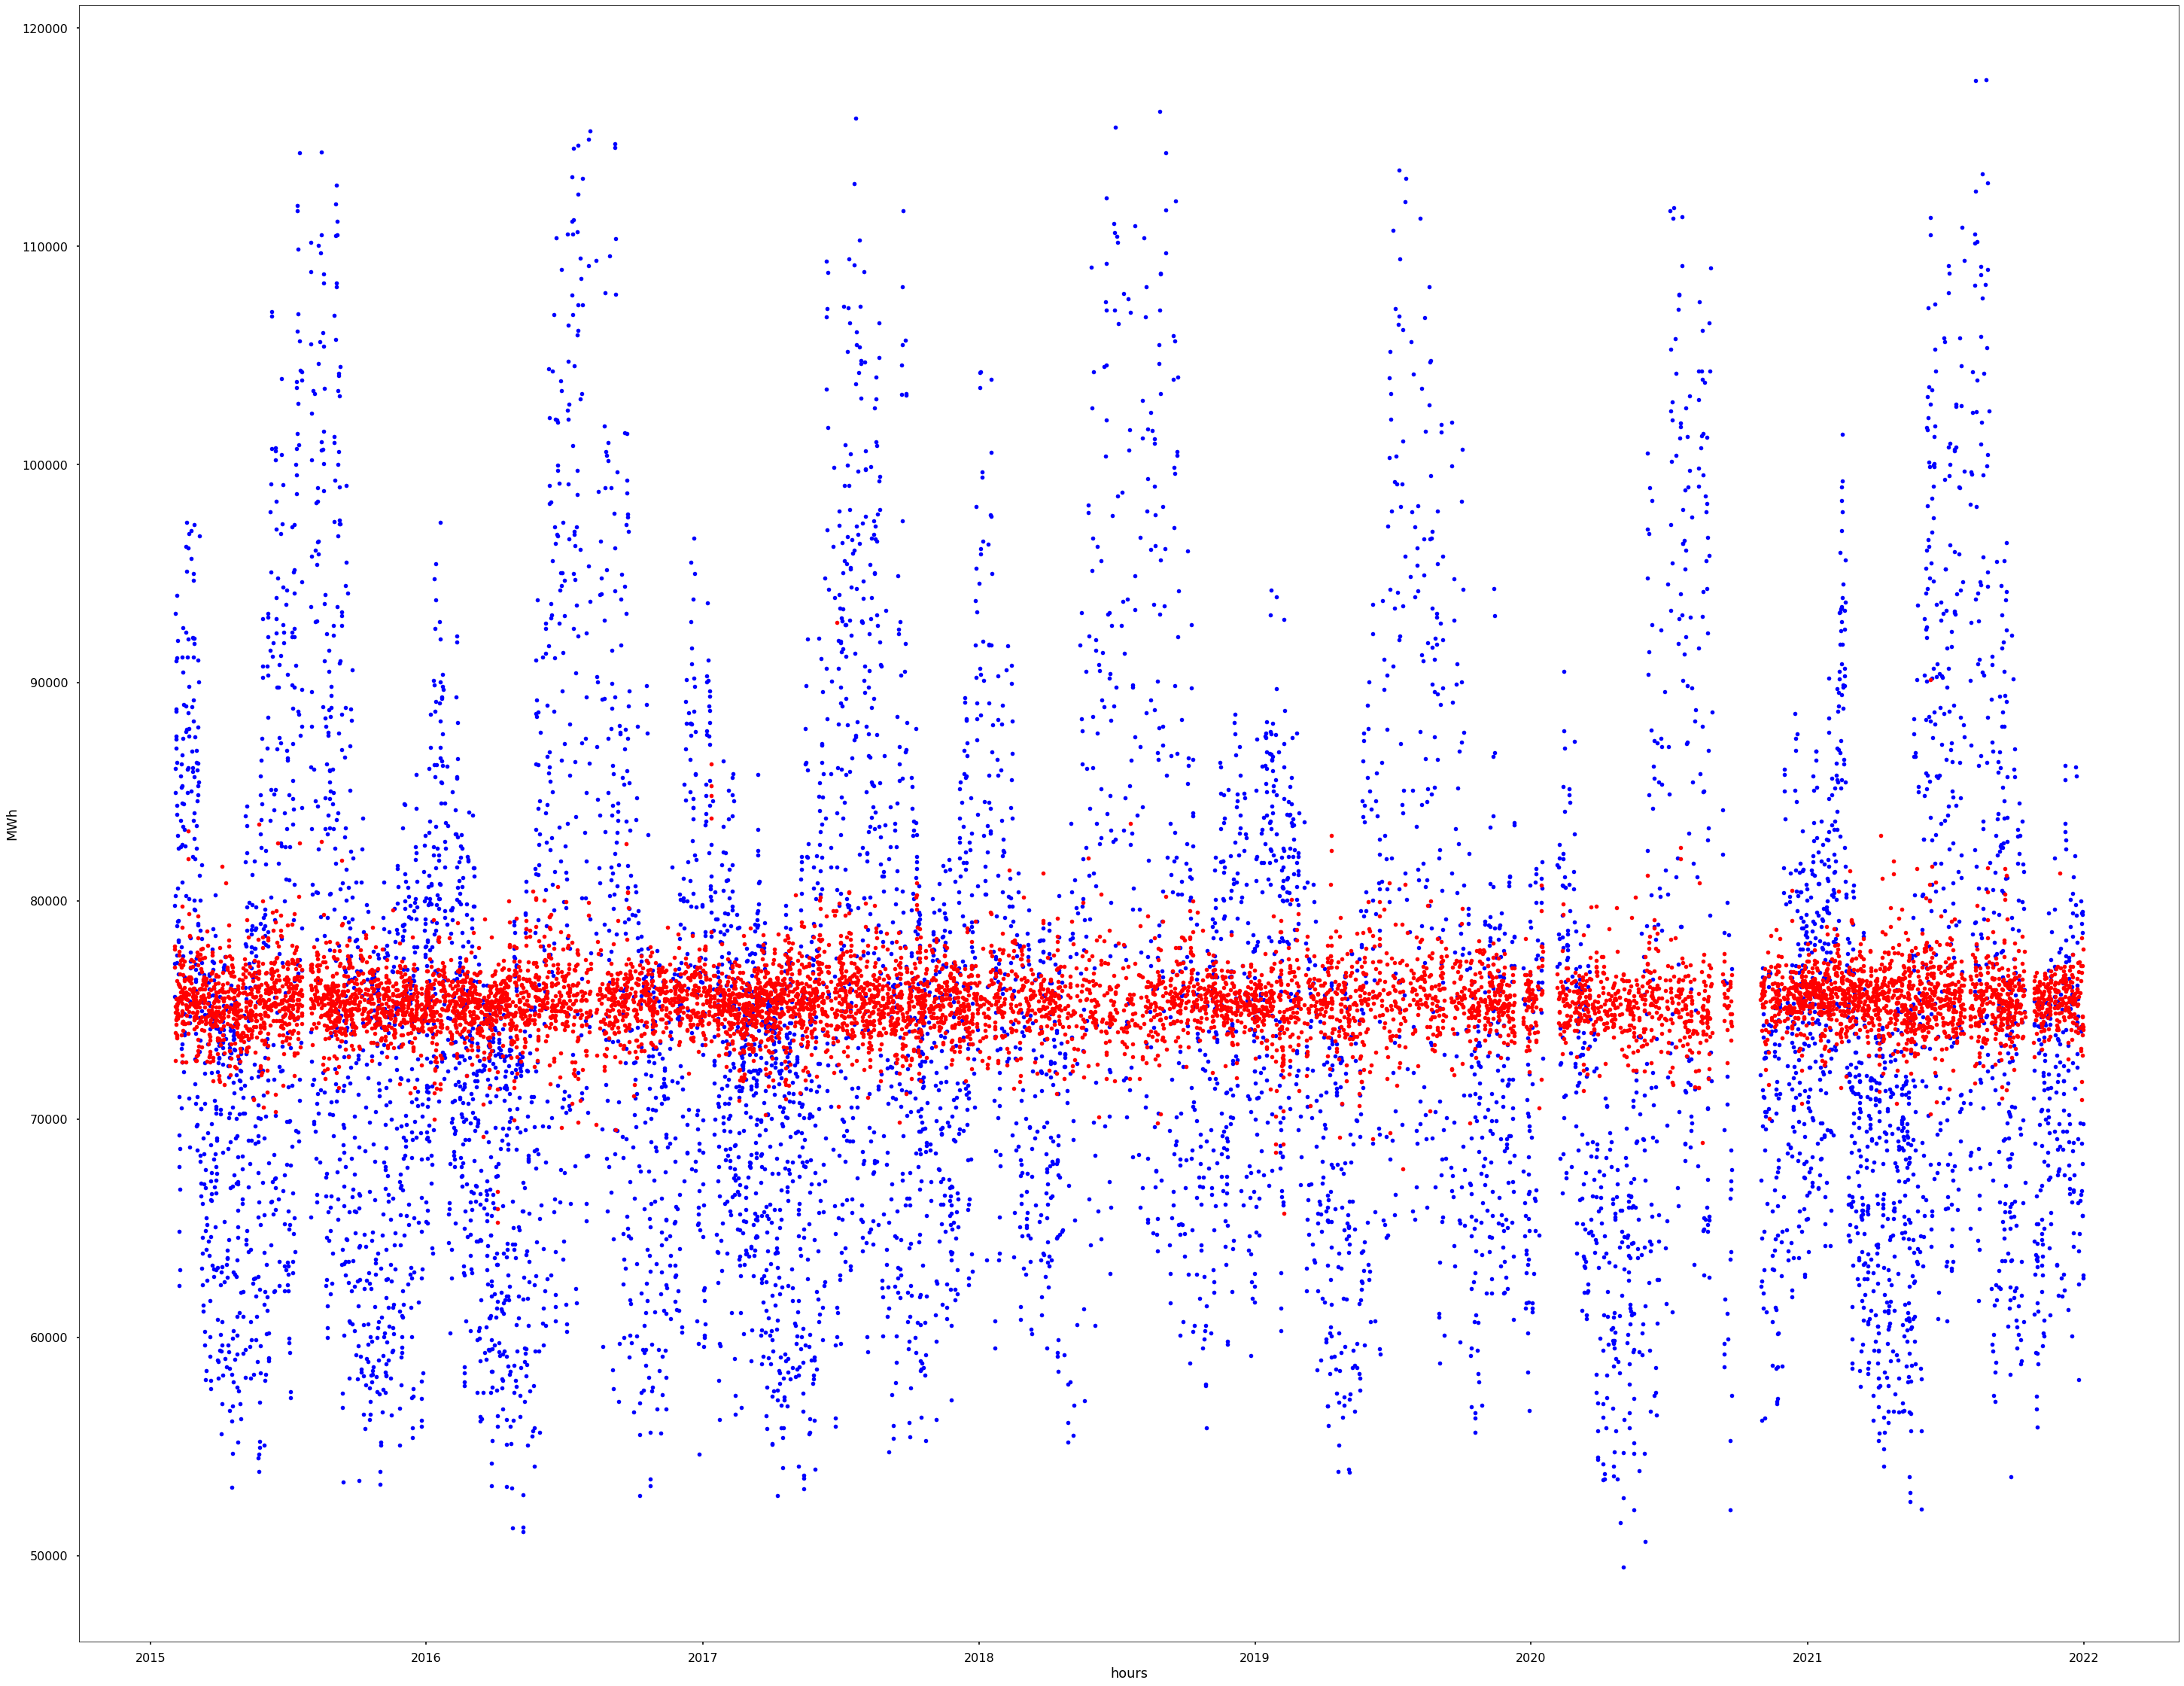

In [108]:
ypred_2 = model.predict(X_test_poly_good)
plot_result(ypred_2, y_test, X_test.index)

In [112]:
better_feature_idx = [i for (i,v) in enumerate(model.pvalues) if v < 0.05]

In [113]:
X_train_poly_better = X_train_poly_good[:,better_feature_idx]
X_test_poly_better = X_test_poly_good[:,better_feature_idx]

model3 = sm.OLS(y_train, X_train_poly_better).fit()

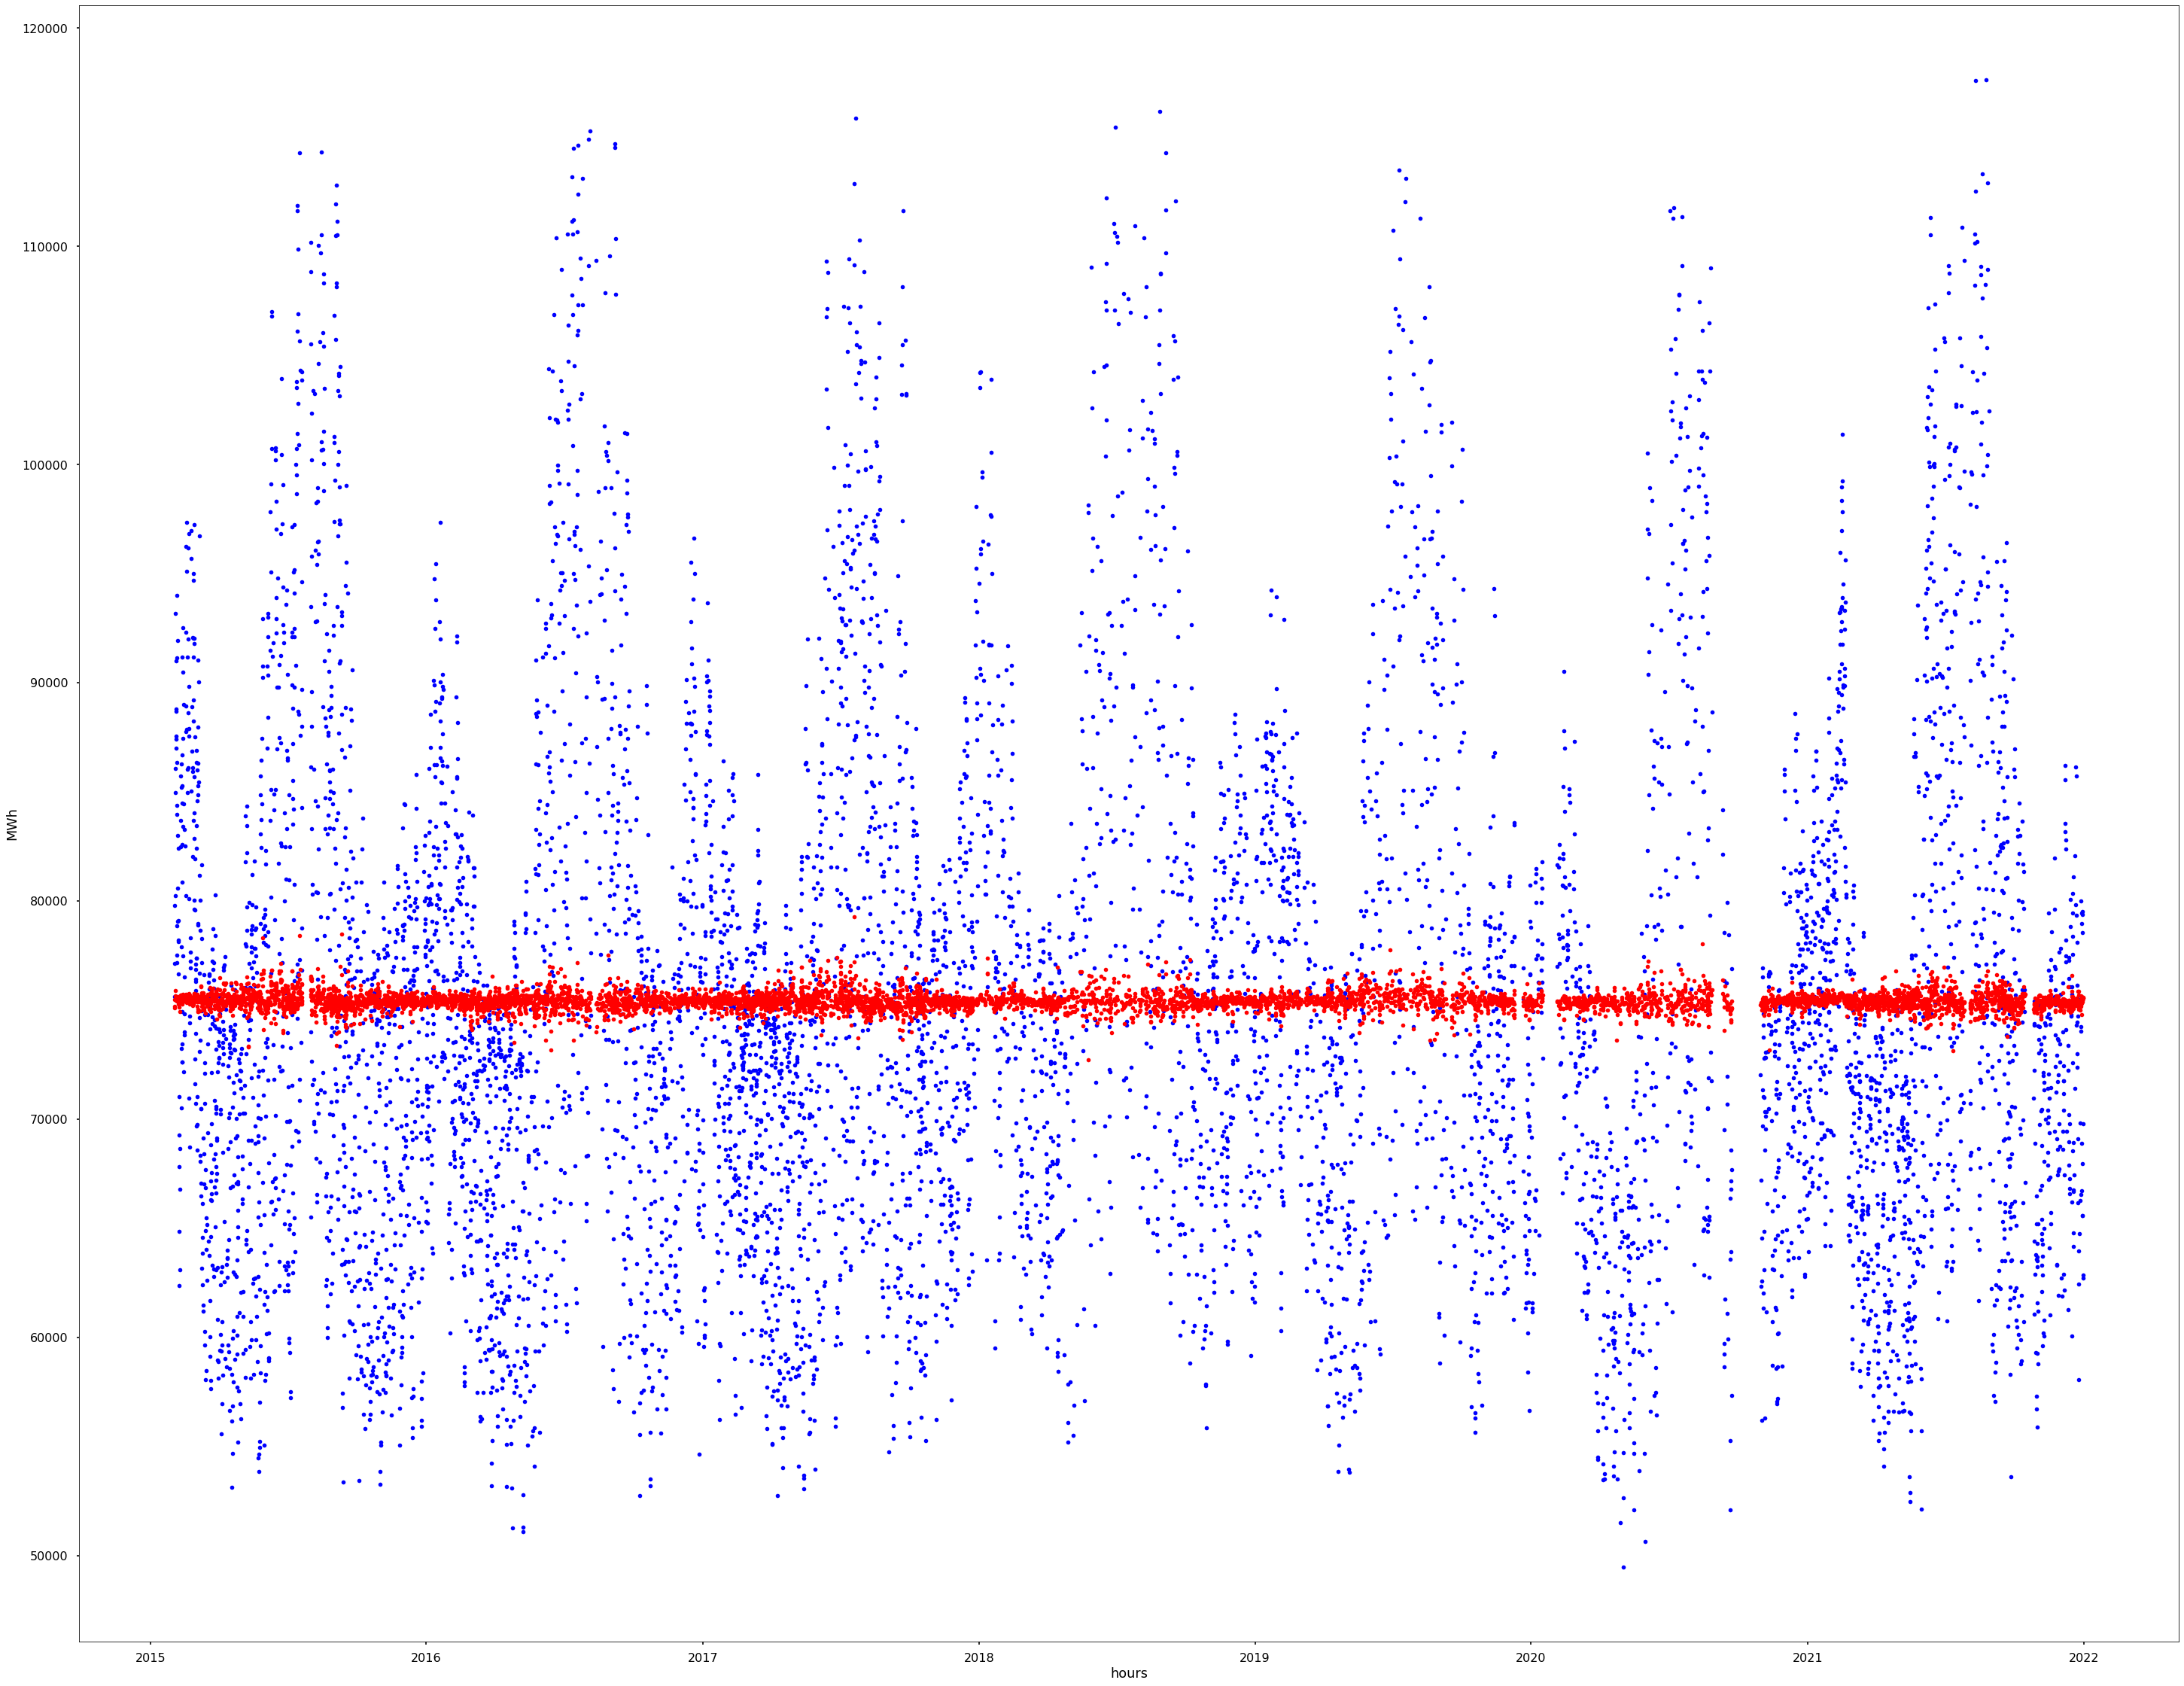

In [114]:
ypred_3 = model3.predict(X_test_poly_better)
plot_result(ypred_3, y_test, X_test.index)

In [115]:
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     MISO ActualLoad (MWh)   R-squared:                       0.001
Model:                               OLS   Adj. R-squared:                  0.000
Method:                    Least Squares   F-statistic:                     1.088
Date:                   Tue, 29 Mar 2022   Prob (F-statistic):              0.334
Time:                           17:47:32   Log-Likelihood:            -3.5079e+05
No. Observations:                  32511   AIC:                         7.016e+05
Df Residuals:                      32477   BIC:                         7.019e+05
Df Model:                             33                                         
Covariance Type:               nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       7.553e+04    182.602    413.611      0.000    7.52e+04    7.59e+04
x1            -0.3857      0.259     -1.490      0.136      -0.893       0.122
x2            -0.0029      0.007     -0.430      0.667      -0.016       0.010
x3             0.0037      0.008      0.444      0.657      -0.013       0.020
x4            -0.0014      0.010     -0.145      0.884      -0.021       0.018
x5            -0.0150      0.049     -0.304      0.761      -0.112       0.082
x6             0.0043      0.003      1.435      0.151      -0.002       0.010
x7             0.0014      0.006      0.250      0.802      -0.010       0.013
x8             0.0245      0.012      2.054      0.040       0.001       0.048
x9            -0.0150      0.014     -1.054      0.292      -0.043       0.013
x10           -0.0149      0.011     -1.303      0.192      -0.037       0.007
x11            0.0148      0.009      1.575      0.115      -0.004       0.033
x12        -4.564e-05      0.018     -0.003      0.998      -0.034       0.034
x13           -0.0025      0.007     -0.370      0.711      -0.016       0.011
x14           -0.0364      0.018     -2.035      0.042      -0.071      -0.001
x15           -0.0245      0.013     -1.919      0.055      -0.049       0.001
x16           -0.0037      0.010     -0.354      0.723      -0.024       0.017
x17           -0.0083      0.015     -0.568      0.570      -0.037       0.020
x18           -0.0025      0.005     -0.543      0.587      -0.012       0.007
x19            0.0417      0.018      2.254      0.024       0.005       0.078
x20            0.0105      0.012      0.840      0.401      -0.014       0.035
x21            0.0085      0.011      0.777      0.437      -0.013       0.030
x22           -0.1895      0.066     -2.880      0.004      -0.318      -0.061
x23            0.2009      0.066      3.030      0.002       0.071       0.331
x24            0.0117      0.006      1.941      0.052      -0.000       0.023
x25            0.0034      0.005      0.703      0.482      -0.006       0.013
x26            0.1800      0.064      2.818      0.005       0.055       0.305
x27           -0.1923      0.064     -3.000      0.003      -0.318      -0.067
x28           -0.0015      0.006     -0.268      0.788      -0.013       0.010
x29           -0.1767      0.066     -2.693      0.007      -0.305      -0.048
x30            0.1705      0.065      2.604      0.009       0.042       0.299
x31           -0.0105      0.005     -2.146      0.032      -0.020      -0.001
x32            0.0010      0.002      0.420      0.674      -0.004       0.006
x33            0.0070      0.006      1.137      0.255      -0.005       0.019
==============================================================================
Omnibus:                     2685.700   Durbin-W

In [128]:
d = X_train.join(y_train)
simple_y_train = d['MISO ActualLoad (MWh)']
simple_X_train = d.drop('MISO ActualLoad (MWh)', axis=1)
simple_model = sm.OLS(simple_y_train, simple_X_train).fit()

In [137]:
simple_X_train.dtypes

DSM               float64
CID               float64
DLH               float64
JKJ               float64
LYV               float64
MSP               float64
RST               float64
MSN               float64
MKE               float64
EAU               float64
GRB               float64
ANJ               float64
GRR               float64
LAN               float64
DET               float64
ARB               float64
EVV               float64
FWA               float64
IND               float64
SBN               float64
SPI               float64
BMI               float64
CMI               float64
ARR               float64
PIA               float64
STL               float64
COU               float64
SGF               float64
MKC               float64
HKS               float64
TUP               float64
MEI               float64
BTR               float64
LFT               float64
LCH               float64
SHV               float64
AEX               float64
LFK               float64
HourEnding  

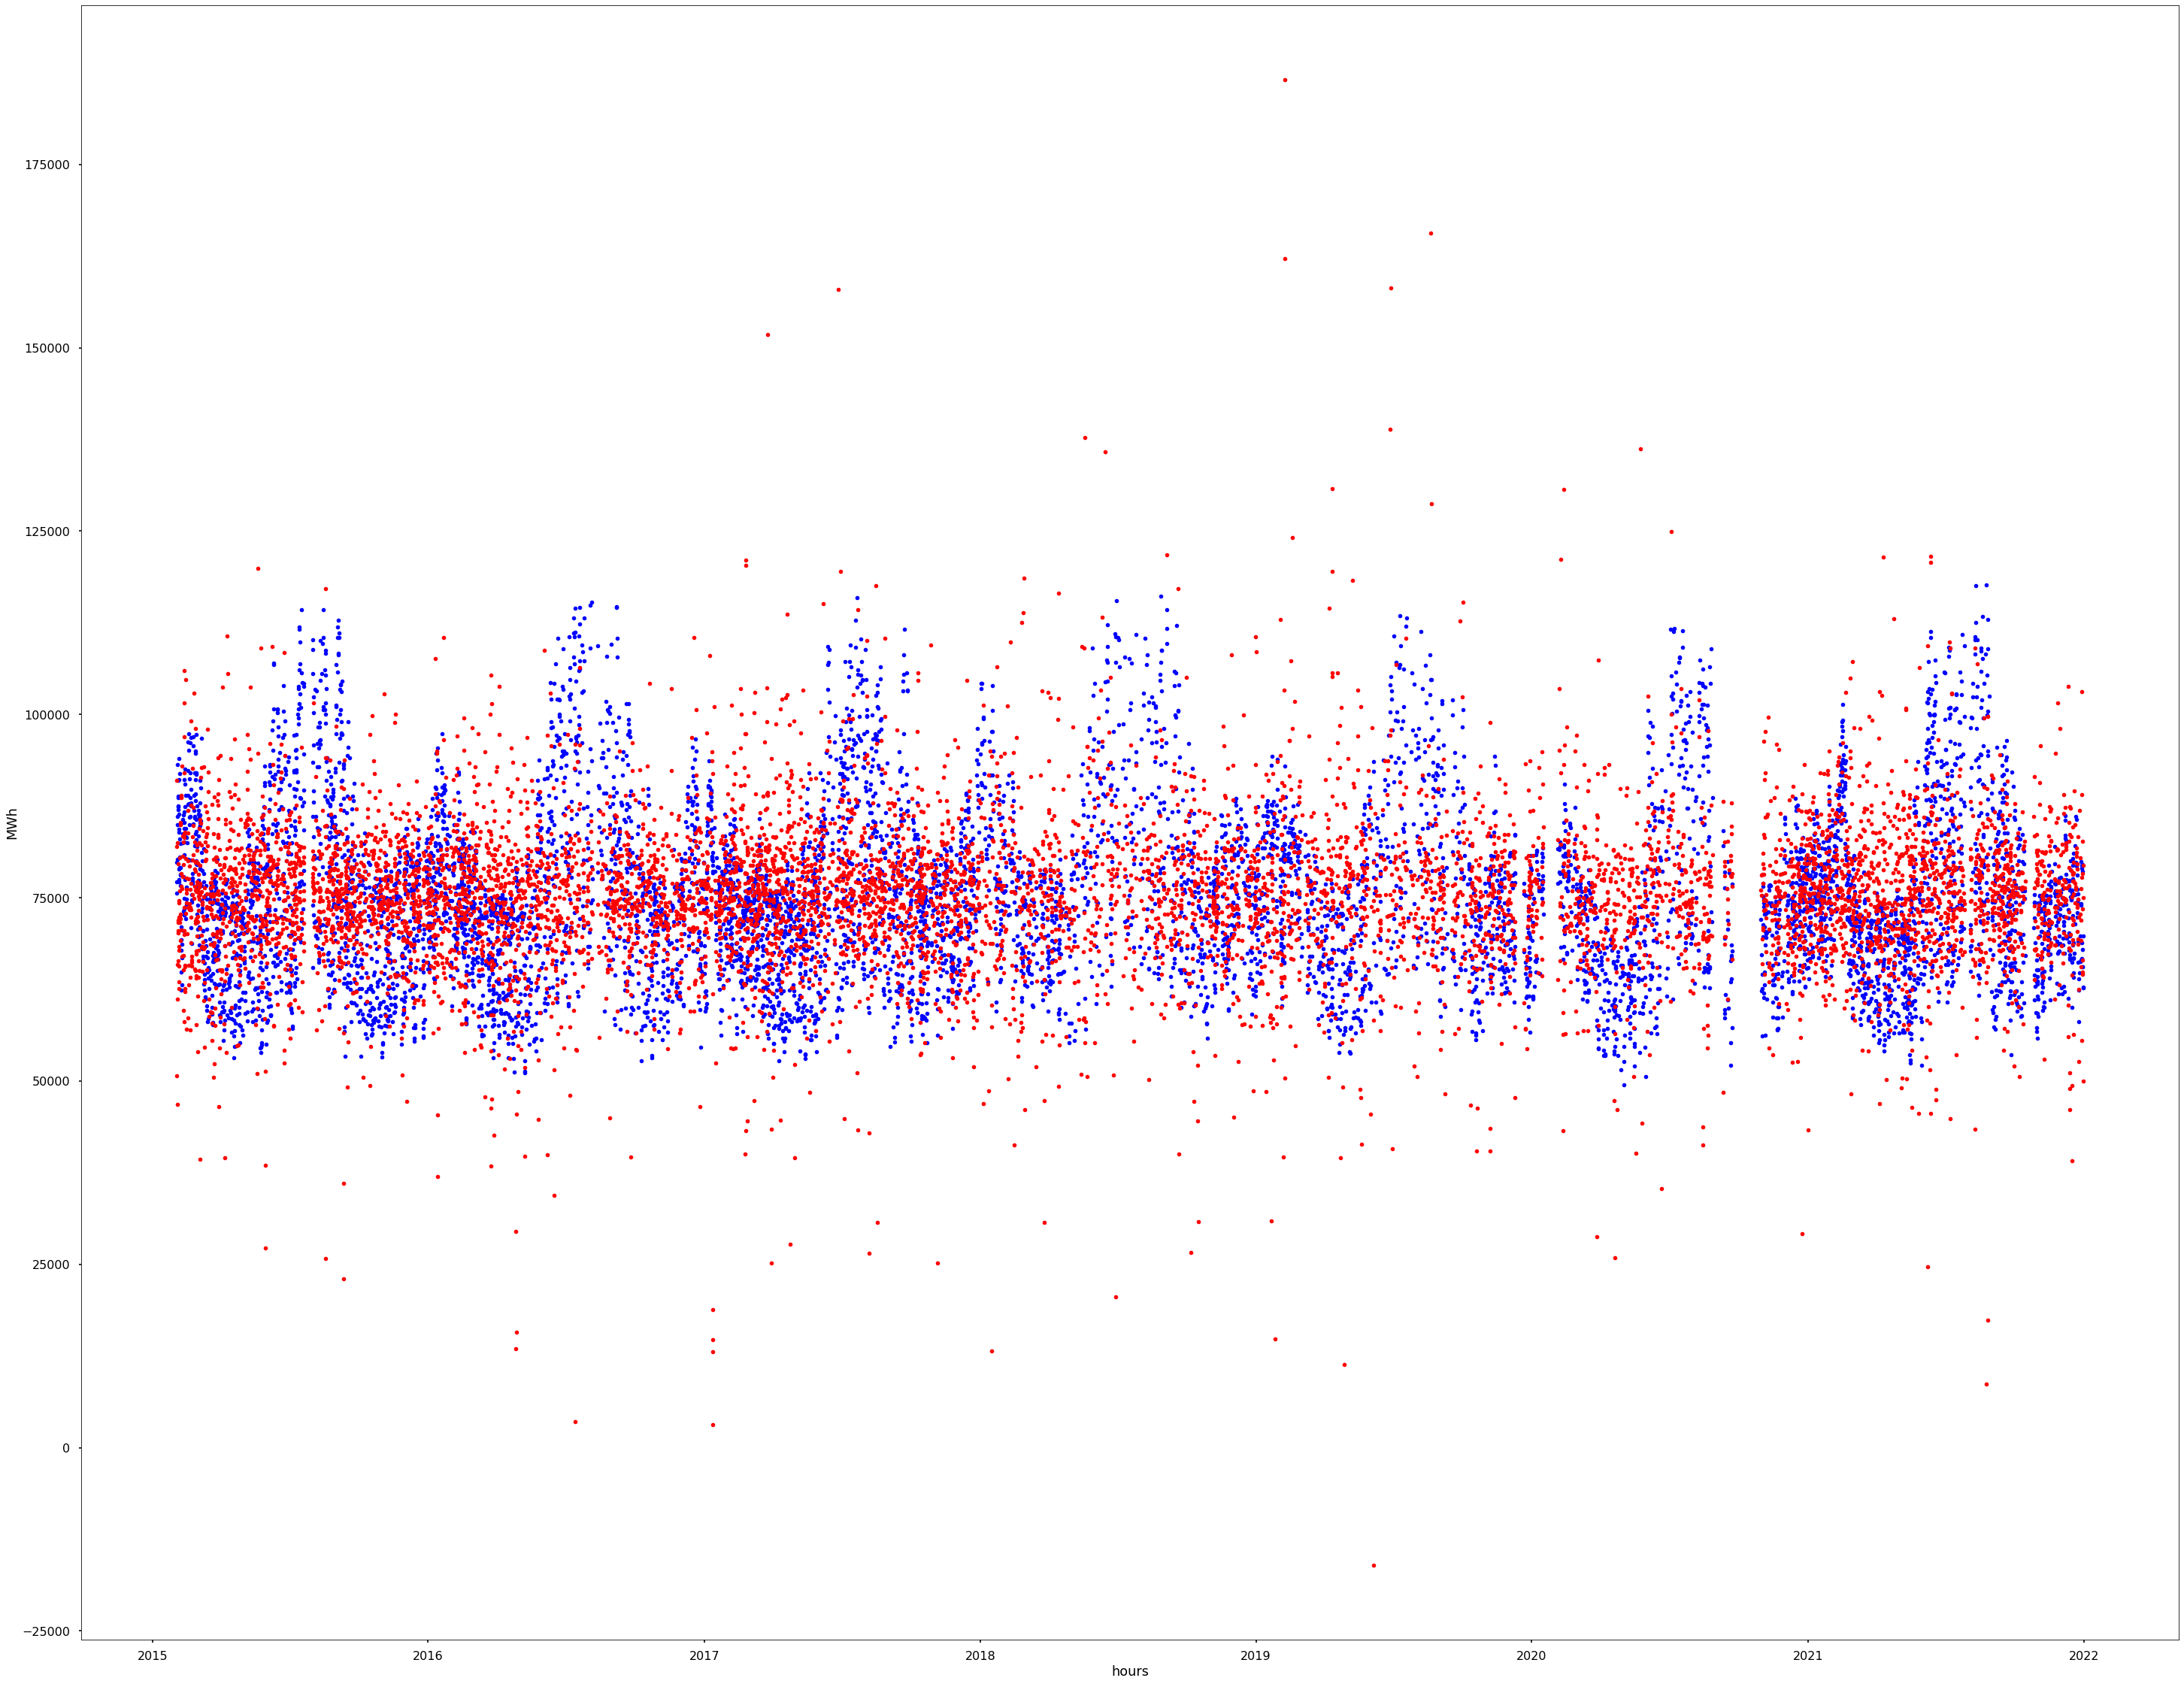

In [129]:
t = X_test.join(y_test)
simple_y_test = t['MISO ActualLoad (MWh)']
simple_X_test = t.drop('MISO ActualLoad (MWh)', axis=1)
simple_ypred = simple_model.predict(simple_X_test)
plot_result(ypred, simple_y_test, X_test.index)

In [132]:
simple_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                  
==========================================================================================
Dep. Variable:     MISO ActualLoad (MWh)   R-squared (uncentered):                   0.975
Model:                               OLS   Adj. R-squared (uncentered):              0.975
Method:                    Least Squares   F-statistic:                          3.137e+04
Date:                   Tue, 29 Mar 2022   Prob (F-statistic):                        0.00
Time:                           18:10:34   Log-Likelihood:                     -3.5182e+05
No. Observations:                  32511   AIC:                                  7.037e+05
Df Residuals:                      32471   BIC:                                  7.041e+05
Df Model:                             40                                                  
Covariance Type:               nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
DSM              -42.1462     24.310     -1.734      0.083     -89.794       5.502
CID             -220.4865     26.318     -8.378      0.000    -272.071    -168.902
DLH             -131.9496     15.242     -8.657      0.000    -161.825    -102.074
JKJ             -113.4672     12.002     -9.454      0.000    -136.992     -89.943
LYV              298.2601     16.236     18.371      0.000     266.438     330.082
MSP               71.4599     25.832      2.766      0.006      20.828     122.091
RST             -343.5607     27.569    -12.462      0.000    -397.597    -289.524
MSN             -187.4622     26.320     -7.122      0.000    -239.050    -135.874
MKE              251.5893     18.922     13.296      0.000     214.501     288.677
EAU             -175.4559     23.888     -7.345      0.000    -222.278    -128.634
GRB              149.9800     23.166      6.474      0.000     104.575     195.385
ANJ               -2.4508     12.652     -0.194      0.846     -27.250      22.349
GRR              729.8367     32.205     22.662      0.000     666.714     792.959
LAN             -390.4403     34.582    -11.290      0.000    -458.223    -322.657
DET              317.7170     24.867     12.777      0.000     268.977     366.457
ARB             -192.2121     23.428     -8.204      0.000    -238.131    -146.293
EVV              163.2793     22.079      7.395      0.000     120.003     206.556
FWA               84.3065     26.936      3.130      0.002      31.511     137.102
IND             -510.8484     26.700    -19.133      0.000    -563.182    -458.515
SBN              149.0590     24.300      6.134      0.000     101.430     196.688
SPI              217.1264     33.916      6.402      0.000     150.651     283.602
BMI             -223.9468     36.300     -6.169      0.000    -295.096    -152.797
CMI             -210.3198     31.551     -6.666      0.000    -272.161    -148.478
ARR             -111.3352     25.174     -4.423      0.000    -160.677     -61.994
PIA              -35.1308     35.107     -1.001      0.317    -103.943      33.681
STL              186.4200     27.454      6.790      0.000     132.610     240.230
COU              -81.6309     27.321     -2.988      0.003    -135.181     -28.081
SGF              -74.9789     19.310     -3.883      0.000    -112.828     -37.130
MKC              408.6659     19.172     21.316      0.000     371.089     446.243
HKS             -169.9484     26.662     -6.374      0.000    -222.208    -117.689
TUP              -84.6648     20.508     -4.128      0.000    -124.862     -44.467
MEI              129.1359     20.651      6.253      0.000      88.660     169.612
BTR              164.9342     28.699      5.74

In [133]:
data

AEX    ANJ    ARB    ARR   BMI    BTR   CID  \
2015-02-01 05:00:00+00:00  55.94   3.02  30.92  33.08  33.8  53.96  32.0   
2015-02-01 06:00:00+00:00  55.04   1.04  32.00  33.08  32.9  53.96  32.0   
2015-02-01 07:00:00+00:00  53.96  -2.02  30.02  33.08  32.9  55.04  32.0   
2015-02-01 08:00:00+00:00  53.96  -4.00  30.02  33.08  32.9  55.94  32.0   
2015-02-01 09:00:00+00:00  53.96  -5.98  28.94  32.00  32.9  55.94  32.0   
...                          ...    ...    ...    ...   ...    ...   ...   
2021-12-31 18:00:00+00:00  82.00  33.10  41.00  37.00  46.9  82.90  28.0   
2021-12-31 19:00:00+00:00  82.90  33.10  42.10  37.00  50.0  82.90  28.0   
2021-12-31 20:00:00+00:00  82.00  33.10  43.00  37.90  51.1  82.90  28.9   
2021-12-31 21:00:00+00:00  82.90  32.00  42.10  39.00  51.1  82.00  28.9   
2021-12-31 22:00:00+00:00  81.00  32.00  41.00  37.90  53.1  81.00  28.9   

                             CMI    COU    DET  ...  HourEnding  \
2015-02-01 05:00:00+00:00  33.08  37.04  33.98  ...           1   
2015-02-01 06:00:00+00:00  33.08  35.06  33.08  ...           2   
2015-02-01 07:00:00+00:00  33.08  33.98  33.08  ...           3   
2015-02-01 08:00:00+00:00  33.08  33.08  30.92  ...           4   
2015-02-01 09:00:00+00:00  33.08  33.08  28.94  ...           5   
...                          ...    ...    ...  ...         ...   
2021-12-31 18:00:00+00:00  50.00  57.90  43.00  ...          14   
2021-12-31 19:00:00+00:00  51.10  60.10  44.10  ...          15   
2021-12-31 20:00:00+00:00  52.00  60.10  45.00  ...          16   
2021-12-31 21:00:00+00:00  53.10  63.00  44.10  ...          17   
2021-12-31 22:00:00+00:00  54.00  59.00  44.10  ...          18   

                           Central MTLF (MWh)  Central ActualLoad (MWh)  \
2015-02-01 05:00:00+00:00               37796                  36585.39   
2015-02-01 06:00:00+00:00               36589                  35509.04   
2015-02-01 07:00:00+00:00               36067                  34970.90   
2015-02-01 08:00:00+00:00               35855                  34708.83   
2015-02-01 09:00:00+00:00               35835                  34709.81   
...                                       ...                       ...   
2021-12-31 18:00:00+00:00               36962                  34639.02   
2021-12-31 19:00:00+00:00               36482                  34292.13   
2021-12-31 20:00:00+00:00               36151                  34236.67   
2021-12-31 21:00:00+00:00               36250                  34516.59   
2021-12-31 22:00:00+00:00               37245                  35899.88   

                           North MTLF (MWh)  North ActualLoad (MWh)  \
2015-02-01 05:00:00+00:00             15885                16150.30   
2015-02-01 06:00:00+00:00             15517                15713.40   
2015-02-01 07:00:00+00:00             15187                15381.56   
2015-02-01 08:00:00+00:00             15060                15239.59   
2015-02-01 09:00:00+00:00             15027                15229.09   
...                                     ...                     ...   
2021-12-31 18:00:00+00:00             19520                18986.41   
2021-12-31 19:00:00+00:00             19486                18907.70   
2021-12-31 20:00:00+00:00             19389                18951.24   
2021-12-31 21:00:00+00:00             19378                19059.35   
2021-12-31 22:00:00+00:00             19716                19663.98   

                           South MTLF (MWh)  South ActualLoad (MWh)  \
2015-02-01 05:00:00+00:00             16067                16163.39   
2015-02-01 06:00:00+00:00             15591                15571.34   
2015-02-01 07:00:00+00:00             15272                15137.39   
2015-02-01 08:00:00+00:00             15122                14935.61   
2015-02-01 09:00:00+00:00             15080                14750.43   
...                                     ...                     ...   
2021-12-31 18:00:00+00:00             20296                1

In [134]:
data.columns

Index(['AEX', 'ANJ', 'ARB', 'ARR', 'BMI', 'BTR', 'CID', 'CMI', 'COU', 'DET',
       'DLH', 'DSM', 'EAU', 'EVV', 'FWA', 'GRB', 'GRR', 'HKS', 'IND', 'JKJ',
       'LAN', 'LCH', 'LFK', 'LFT', 'LYV', 'MEI', 'MKC', 'MKE', 'MSN', 'MSP',
       'PIA', 'RST', 'SBN', 'SGF', 'SHV', 'SPI', 'STL', 'TUP', 'Market Day',
       'HourEnding', 'Central MTLF (MWh)', 'Central ActualLoad (MWh)',
       'North MTLF (MWh)', 'North ActualLoad (MWh)', 'South MTLF (MWh)',
       'South ActualLoad (MWh)', 'MISO MTLF (MWh)', 'MISO ActualLoad (MWh)',
       'IsBusinessHour'],
      dtype='object')

In [135]:
data.to_parquet('./data/harmonized_data.parquet')